In [32]:
import Environment
import Shop
from mab.ts_learner import *
from mab.ucb_learner import *
from utilities import *

In [33]:
shop_ts = Shop.Shop()
shop_ucb = Shop.Shop()

shop_ts_normalized = Shop.Shop()


shop_clairvoyant = Shop.Shop()

env = Environment.Environment(shop_clairvoyant.prices1,shop_clairvoyant.prices2,shop_clairvoyant.discounts)

# The environment decides the conversion rates, which are shared among all the shops.
shop_clairvoyant.set_conv_rate(env.true_conv1, env.true_conv2)
shop_ts.set_conv_rate(env.true_conv1,env.true_conv2)
shop_ucb.set_conv_rate(env.true_conv1, env.true_conv2)

#Initialize learners
shop_ts.set_price_learner('TS')
shop_ucb.set_price_learner('UCB')

In [34]:
env.true_conv2.shape

(4, 4, 5)

In [35]:
# we have fixed promo fractions
promo_fractions = np.array([[0.3, 0.2, 0.25, 0.25],     # every row is a customer class
                            [0.2, 0.25, 0.30, 0.25],     # every column is a promo type   
                            [0.1, 0.2, 0.3, 0.4],
                            [0.15, 0.15, 0.45, 0.25]])
                            
# we have a fixed price for item 2
price2_index = 2
price2 = env.prices2[price2_index]
conv2 = shop_ts.conv2[:,:,price2_index] # rows -> promo, columns -> customer class
max_ind_reward = price2 + max(env.prices1)

In [40]:
#### get clairvoyant price
expected_rewards = np.array([0.0, 0.0, 0.0, 0.0, 0.0])
customers_mean = np.array([25, 25, 25, 25])

for i in range(len(env.prices1)):
    for j in range(env.n_classes):
        expected_reward_from_class = customers_mean[j]*env.prices1[i]*env.true_conv1[j, i]
        print("Expected reward from item 1 for price-class", i, "-", j, "----->", expected_reward_from_class)
        for k in range(len(env.discounts)):
            expected_reward_from_class += promo_fractions[j,k]*customers_mean[j]*env.true_conv1[j, i]*price2*env.true_conv2[k, j, i]*(1 - env.discounts[k])
        expected_rewards[i] += expected_reward_from_class

        print("Expected Reward for Price", i, "from class", j, "--->", expected_reward_from_class)
        print("************")

print(env.prices1)
print(expected_rewards)

clairvoyant_price_index = np.argmax(expected_rewards)
clairvoyant_price = env.prices1[clairvoyant_price_index]


Expected reward from item 1 for price-class 0 - 0 -----> 1669.2457112508241
Expected Reward for Price 0 from class 0 ---> 4768.870463079102
************
Expected reward from item 1 for price-class 0 - 1 -----> 1885.650733724828
Expected Reward for Price 0 from class 1 ---> 5446.328806547334
************
Expected reward from item 1 for price-class 0 - 2 -----> 1552.7890672311737
Expected Reward for Price 0 from class 2 ---> 4512.430003709629
************
Expected reward from item 1 for price-class 0 - 3 -----> 963.8760721090389
Expected Reward for Price 0 from class 3 ---> 2448.093107754835
************
Expected reward from item 1 for price-class 1 - 0 -----> 2372.514627214513
Expected Reward for Price 1 from class 0 ---> 4814.278143136945
************
Expected reward from item 1 for price-class 1 - 1 -----> 2429.6319199501213
Expected Reward for Price 1 from class 1 ---> 4814.902285446385
************
Expected reward from item 1 for price-class 1 - 2 -----> 1931.698076686495
Expected R

In [41]:
print(max_ind_reward)
print(clairvoyant_price)

440.0
80.0


In [42]:
shop_clairvoyant.best_promo_per_class(chosen_price2=price2_index)
shop_clairvoyant.best_price

(80.0, 200.0)
710.9998904355878
*******
(120.0, 200.0)
791.679882284017
*******
(160.0, 200.0)
809.0814329931706
*******
(200.0, 200.0)
695.6608244117394
*******
(240.0, 200.0)
566.4934601196163
*******


(160.0, 200.0)

In [43]:
days = 365

ts_rewards_per_class_per_day = []
u_rewards_per_class_per_day = []
clairvoyant_per_class_per_day = []
c_expected_per_day = []

customers_em = np.array([0, 0, 0, 0])
customers_ie = np.array([25, 25, 25, 25])

prices_selected_ts = []
prices_selected_ucb = []
for day in range(days):
    #### same as step 3
    


    
    if day == 0:
        shop_clairvoyant.set_expected_customers(customers_ie)
        shop_ts.set_expected_customers(customers_ie)
        shop_ucb.set_expected_customers(customers_ie)
        shop_ts_normalized.set_expected_customers(customers_ie)
        
    else:
        customers_em = (customers_em*(day-1) + env.customers) / day
        print(env.customers)
        print(customers_em)
        print("***************")
        shop_clairvoyant.set_expected_customers((customers_em + 0.99).astype(int))
        shop_ts.set_expected_customers((customers_em + 0.99).astype(int))
        shop_ucb.set_expected_customers((customers_em + 0.99).astype(int))
        shop_ts_normalized.set_expected_customers((customers_em + 0.99).astype(int))
        
    env.generate_next_day_customers()


    ### TODO BIG DECISIONS HERE
    chosen_price_ts = shop_ts.price_learner.pull_arm()
    chosen_price_ucb = shop_ucb.price_learner.pull_arm()

    #chosen_price_ts_normalized = shop_ts_normalized.price_learner.pull_arm_normalized()
    
    ### TODO ADDING NORMALIZATION

    prices_selected_ts.append(env.prices1[chosen_price_ts])
    prices_selected_ucb.append((env.prices1[chosen_price_ucb], env.customers.sum()))

    ##### Will print coupons manually here
    ##### The Ratios are fixed

    clairvoyant_n_promos = (shop_clairvoyant.customers*promo_fractions + 0.99).astype(int)
    ts_n_promos = (shop_ts.customers*promo_fractions + 0.99).astype(int)
    ucb_n_promos = (shop_ucb.customers*promo_fractions + 0.99).astype(int)

    clairvoyant_promos = [list(enumerate(l)) for l in clairvoyant_n_promos]
    ts_promos = [list(enumerate(l)) for l in ts_n_promos]
    ucb_promos = [list(enumerate(l)) for l in ucb_n_promos]

    clairvoyant_promos = [np.concatenate([np.ones(c).astype(int)*p for p,c in promo]) for promo in clairvoyant_promos]
    ts_promos = [np.concatenate([np.ones(c).astype(int)*p for p,c in promo]) for promo in ts_promos]
    ucb_promos = [np.concatenate([np.ones(c).astype(int)*p for p,c in promo]) for promo in ucb_promos]

    

    
    for i in range(4):
        np.random.shuffle(clairvoyant_promos[i])
        np.random.shuffle(ts_promos[i])
        np.random.shuffle(ucb_promos[i])

    clairvoyant_promos = [list(promo) for promo in clairvoyant_promos]
    ts_promos = [list(promo) for promo in ts_promos]
    ucb_promos = [list(promo) for promo in ucb_promos]

    promos = clairvoyant_promos*2


    #### Will create list of customers
    #### since it is normally done in print coupons I do it manually here
    #### we probably need to separate printing the coupons and setting customer list


    enum_customers = list(enumerate(env.customers))
    customers = np.concatenate([np.ones(c).astype(int)*p for p,c in enum_customers])
    np.random.shuffle(customers)

    c_expected_revenue = []
    revenue_c = []
    revenue_ts = [] 
    revenue_ucb = []    
    c_count = 0
    ts_total_reward = 0
    ts_norm_reward = 0
    ucb_total_reward = 0
    ucb_norm_reward = 0
    times_bought = 0
    for cust in customers:
        c_count += 1
        ts_ind_reward = 0
        ucb_ind_reward = 0

        # assign the promo to the incoming customer
        """ts_selected_promo = 0
        ucb_selected_promo = 0
        clairvoyant_selected_promo = 0

        if len(ts_promos[cust]) > 0:
            ts_selected_promo = ts_promos[cust].pop(0)
        if len(ucb_promos[cust]) > 0:
            ucb_selected_promo = ucb_promos[cust].pop(0)
        if len(clairvoyant_promos[cust]) > 0:
            clairvoyant_selected_promo = clairvoyant_promos[cust].pop(0)"""
        selected_promo = 0
        if len(promos[cust]) > 0:
            selected_promo = promos[cust].pop()

        # customer does their shopping
        cr1 = shop_clairvoyant.conv1[cust, clairvoyant_price_index]
        cr2 = shop_clairvoyant.conv2[selected_promo, cust, price2_index]
        ex_ind = clairvoyant_price*cr1 + price2*cr1*cr2*(1-shop_clairvoyant.discounts[selected_promo])   
        c_expected_revenue.append(ex_ind)
        
        #print(chosen_price_ts[0])
        ts_buy1 = env.round1(cust, env.prices1[chosen_price_ts])
        ts_buy2 = 0
        if ts_buy1:
            ts_buy2 = env.round2(cust, selected_promo, price2)
        
        ucb_buy1 = env.round1(cust, env.prices1[chosen_price_ucb])
        ucb_buy2 = 0
        if ucb_buy1:
            ucb_buy2 = env.round2(cust, selected_promo, price2)

        c_buy1 = env.round1(cust, clairvoyant_price)
        c_buy2 = 0
        if c_buy1:
            c_buy2 = env.round2(cust, selected_promo, price2)
        
        
        # calculate individual reward
        
        ts_ind_reward = ts_buy1*shop_ts.prices1[chosen_price_ts[0]] + ts_buy2*price2*(1-shop_ts.discounts[selected_promo])
        ucb_ind_reward = ucb_buy1*shop_ucb.prices1[chosen_price_ucb] + ucb_buy2*price2*(1-shop_ucb.discounts[selected_promo])
        c_ind_reward = c_buy1*clairvoyant_price + c_buy2*price2*(1-shop_clairvoyant.discounts[selected_promo])

        norm_ts_ind_reward = ts_ind_reward / max_ind_reward
        norm_ucb_ind_reward = ucb_ind_reward / max_ind_reward

        # can update probablities here after each customer
        # not doing it right now

        ### TODO BIG DECISIONS HERE
        shop_ts.price_learner.update(chosen_price_ts, ts_buy1, cust)
        #shop_ucb.price_learner.update(chosen_price_ucb, ucb_buy1, cust)

        # summing up the reward for the day
        ts_total_reward += ts_ind_reward
        ucb_total_reward += ucb_ind_reward

        ts_norm_reward += norm_ts_ind_reward
        ucb_norm_reward += norm_ucb_ind_reward

        revenue_ts.append(ts_ind_reward)
        revenue_ucb.append(ucb_ind_reward)
        revenue_c.append(c_ind_reward)

    shop_ucb.price_learner.update(chosen_price_ucb, ucb_buy1, cust)

    ts_rewards_per_class_per_day.append(np.mean(revenue_ts))
    u_rewards_per_class_per_day.append(np.mean(revenue_ucb))
    clairvoyant_per_class_per_day.append(np.mean(revenue_c))
    c_expected_per_day.append(np.mean(c_expected_revenue))

    ts_daily_norm_reward = ts_norm_reward / len(customers)
    ucb_daily_norm_reward = ucb_norm_reward / len(customers)

    #shop_ts.price_learner.update(chosen_price_ts, ts_daily_norm_reward, cust)
    #shop_ucb.price_learner.update(chosen_price_ucb, ucb_daily_norm_reward, cust)

    """print("DAY", day)
    print("Price for the day:", env.prices1[chosen_price_ts])
    print("Max individual reward:", max_ind_reward)
    print("Maximum daily Reward:", max_ind_reward*len(customers))
    print("Reward earned:", ts_total_reward)
    print("The score of the day:", ts_daily_norm_reward)
    print(times_bought, "customers out of", len(customers), "bought item 1")
    print("\n*******************\n")"""


[37 22 13 25]
[37. 22. 13. 25.]
***************
[22 14 24 16]
[29.5 18.  18.5 20.5]
***************
[25 14 37 19]
[28.         16.66666667 24.66666667 20.        ]
***************
[12 23 28 23]
[24.   18.25 25.5  20.75]
***************
[22 24 28 22]
[23.6 19.4 26.  21. ]
***************
[27 32 20 24]
[24.16666667 21.5        25.         21.5       ]
***************
[25 35 32 37]
[24.28571429 23.42857143 26.         23.71428571]
***************
[12 37 33 24]
[22.75  25.125 26.875 23.75 ]
***************
[37 14 37 31]
[24.33333333 23.88888889 28.         24.55555556]
***************
[35 16 37 30]
[25.4 23.1 28.9 25.1]
***************
[20 25 12 27]
[24.90909091 23.27272727 27.36363636 25.27272727]
***************
[28 18 28 17]
[25.16666667 22.83333333 27.41666667 24.58333333]
***************
[19 20 20 37]
[24.69230769 22.61538462 26.84615385 25.53846154]
***************
[18 23 22 23]
[24.21428571 22.64285714 26.5        25.35714286]
***************
[32 17 37 37]
[24.73333333 22.26666667 2

In [44]:
print(np.cumsum(clairvoyant_per_class_per_day)[-1] - np.cumsum(ts_rewards_per_class_per_day)[-1])

-844.6269361644809


In [25]:
customers_em

array([24.04945055, 25.16483516, 24.17307692, 24.28021978])

In [26]:
env.true_conv2.shape

(4, 4, 5)

Text(0, 0.5, 'Revenue')

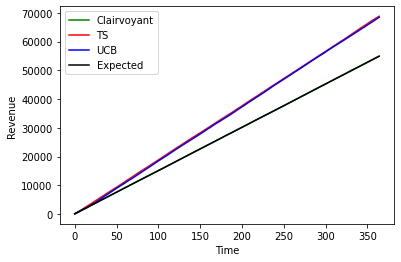

In [27]:
import matplotlib.pyplot as plt
plt.plot(np.cumsum(clairvoyant_per_class_per_day), color='green', label='Clairvoyant')
plt.plot(np.cumsum(ts_rewards_per_class_per_day), color='red', label='TS')
plt.plot(np.cumsum(u_rewards_per_class_per_day), color='blue', label='UCB')
plt.plot(np.cumsum(c_expected_per_day), color='black', label='Expected')

plt.legend()
plt.xlabel('Time')
plt.ylabel('Revenue')

Text(0, 0.5, 'Regret')

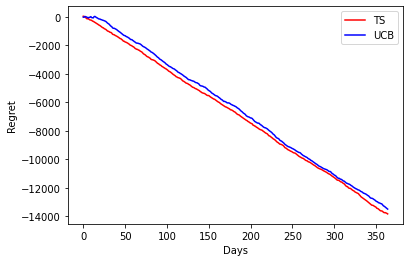

In [28]:
plt.plot(np.cumsum(np.array(clairvoyant_per_class_per_day) - np.array(ts_rewards_per_class_per_day)), color='red', label='TS')
plt.plot(np.cumsum(np.array(clairvoyant_per_class_per_day) - np.array(u_rewards_per_class_per_day)), color='blue', label='UCB')

plt.legend()
plt.xlabel('Days')
plt.ylabel('Regret')

Text(0, 0.5, 'Regret')

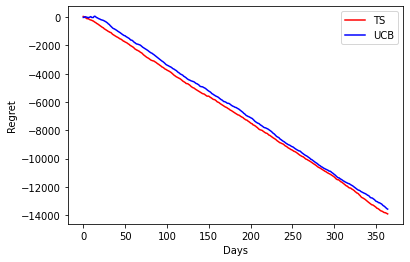

In [29]:
plt.plot(np.cumsum(np.array(c_expected_per_day) - np.array(ts_rewards_per_class_per_day)), color='red', label='TS')
plt.plot(np.cumsum(np.array(c_expected_per_day) - np.array(u_rewards_per_class_per_day)), color='blue', label='UCB')

plt.legend()
plt.xlabel('Days')
plt.ylabel('Regret')

In [30]:
prices_selected_ucb

[(80.0, 112),
 (120.0, 120),
 (240.0, 129),
 (200.0, 116),
 (120.0, 83),
 (200.0, 71),
 (160.0, 119),
 (240.0, 118),
 (80.0, 97),
 (240.0, 97),
 (160.0, 118),
 (80.0, 90),
 (80.0, 106),
 (240.0, 93),
 (80.0, 91),
 (160.0, 94),
 (160.0, 104),
 (160.0, 89),
 (160.0, 69),
 (160.0, 110),
 (160.0, 92),
 (160.0, 99),
 (160.0, 116),
 (160.0, 77),
 (160.0, 81),
 (160.0, 85),
 (160.0, 80),
 (160.0, 99),
 (160.0, 91),
 (160.0, 87),
 (160.0, 85),
 (160.0, 83),
 (160.0, 104),
 (160.0, 84),
 (160.0, 112),
 (160.0, 115),
 (160.0, 98),
 (160.0, 94),
 (160.0, 96),
 (160.0, 72),
 (160.0, 78),
 (160.0, 117),
 (160.0, 102),
 (160.0, 108),
 (160.0, 109),
 (160.0, 97),
 (160.0, 134),
 (160.0, 104),
 (160.0, 99),
 (160.0, 80),
 (160.0, 79),
 (160.0, 89),
 (160.0, 110),
 (160.0, 115),
 (160.0, 84),
 (160.0, 94),
 (160.0, 79),
 (160.0, 100),
 (160.0, 90),
 (160.0, 138),
 (160.0, 91),
 (160.0, 107),
 (160.0, 113),
 (160.0, 117),
 (160.0, 98),
 (160.0, 84),
 (160.0, 83),
 (160.0, 98),
 (160.0, 132),
 (160.0, 98

In [31]:
prices_selected_ts

[240.0,
 200.0,
 160.0,
 160.0,
 160.0,
 160.0,
 200.0,
 160.0,
 160.0,
 200.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 120.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 200.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,
 160.0,


In [57]:
shop_clairvoyant.best_price[0]

120.0

In [98]:
shop_ts.conv2[0]

array([[0.82275883, 0.53730877, 0.20259276, 0.18500068, 0.09976736],
       [0.73380116, 0.71723556, 0.49091563, 0.42960149, 0.03808436],
       [0.41578045, 0.39669945, 0.322431  , 0.10783726, 0.10088497],
       [0.9955141 , 0.50456722, 0.46713713, 0.27326046, 0.26527113]])

In [99]:
shop_ts.conv1 # columns -> price, rows -> customer class

array([[0.92097466, 0.88612658, 0.5066695 , 0.29436634, 0.14070728],
       [0.98627343, 0.89719993, 0.79220109, 0.64301949, 0.31419192],
       [0.83575422, 0.79895927, 0.47231   , 0.16192469, 0.07582633],
       [0.96055015, 0.59600648, 0.55325878, 0.50597405, 0.11468098]])

In [100]:
shop_ts.conv2 # columns -> price, rows -> customer class, # matrices -> promo

array([[[0.82275883, 0.53730877, 0.20259276, 0.18500068, 0.09976736],
        [0.73380116, 0.71723556, 0.49091563, 0.42960149, 0.03808436],
        [0.41578045, 0.39669945, 0.322431  , 0.10783726, 0.10088497],
        [0.9955141 , 0.50456722, 0.46713713, 0.27326046, 0.26527113]],

       [[0.92568641, 0.89065867, 0.60425721, 0.3419471 , 0.08976904],
        [0.89269093, 0.83809266, 0.65353083, 0.34752648, 0.02703086],
        [0.7207825 , 0.71320349, 0.68393057, 0.29335535, 0.00161897],
        [0.77959349, 0.62534955, 0.53471751, 0.47829161, 0.11410822]],

       [[0.6996268 , 0.66991788, 0.49915934, 0.31269671, 0.04134878],
        [0.73808023, 0.52777742, 0.38299047, 0.08498711, 0.05844378],
        [0.63199044, 0.60271942, 0.44105023, 0.14468139, 0.10936959],
        [0.95999684, 0.56483875, 0.56291336, 0.51757067, 0.00629203]],

       [[0.62457555, 0.5602291 , 0.28409276, 0.18874575, 0.00576558],
        [0.9917865 , 0.87081092, 0.86680488, 0.46958083, 0.23683812],
        [0.991

In [103]:
shop_ts.conv2[:,:,0] ### rows-> promos, columns -> customer class

array([[0.82275883, 0.73380116, 0.41578045, 0.9955141 ],
       [0.92568641, 0.89269093, 0.7207825 , 0.77959349],
       [0.6996268 , 0.73808023, 0.63199044, 0.95999684],
       [0.62457555, 0.9917865 , 0.9912417 , 0.98346126]])

In [101]:
shop_ts.conv2[0] # conv rate under promo 0

array([[0.82275883, 0.53730877, 0.20259276, 0.18500068, 0.09976736],
       [0.73380116, 0.71723556, 0.49091563, 0.42960149, 0.03808436],
       [0.41578045, 0.39669945, 0.322431  , 0.10783726, 0.10088497],
       [0.9955141 , 0.50456722, 0.46713713, 0.27326046, 0.26527113]])

In [113]:
chosen_price_ts[0]

4

In [13]:
prices_selected_ts

[200.0,
 360.0,
 560.0,
 800.0,
 80.0,
 360.0,
 200.0,
 80.0,
 360.0,
 360.0,
 560.0,
 200.0,
 360.0,
 560.0,
 360.0,
 560.0,
 200.0,
 360.0,
 360.0,
 560.0,
 560.0,
 560.0,
 560.0,
 360.0,
 560.0,
 560.0,
 80.0,
 560.0,
 560.0,
 360.0,
 360.0,
 560.0,
 560.0,
 560.0,
 560.0,
 560.0,
 360.0,
 360.0,
 560.0,
 360.0,
 360.0,
 560.0,
 360.0,
 360.0,
 560.0,
 560.0,
 560.0,
 560.0,
 560.0,
 360.0,
 360.0,
 560.0,
 560.0,
 560.0,
 560.0,
 360.0,
 560.0,
 560.0,
 360.0,
 560.0,
 360.0,
 560.0,
 560.0,
 560.0,
 360.0,
 560.0,
 560.0,
 560.0,
 560.0,
 560.0,
 560.0,
 560.0,
 560.0,
 560.0,
 560.0,
 560.0,
 360.0,
 560.0,
 560.0,
 360.0,
 560.0,
 560.0,
 360.0,
 560.0,
 560.0,
 560.0,
 560.0,
 560.0,
 360.0,
 560.0,
 560.0,
 560.0,
 560.0,
 360.0,
 560.0,
 360.0,
 560.0,
 560.0,
 560.0,
 560.0,
 560.0,
 560.0,
 560.0,
 560.0,
 560.0,
 560.0,
 560.0,
 560.0,
 560.0,
 560.0,
 560.0,
 360.0,
 560.0,
 560.0,
 560.0,
 560.0,
 360.0,
 560.0,
 560.0,
 360.0,
 360.0,
 560.0,
 560.0,
 360.0,
 560.0,
 56

In [14]:
prices_selected_ucb

[560.0,
 200.0,
 360.0,
 80.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 800.0,
 